In [1]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

from typing import List, Optional, Set

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROJECT_ROOT = "/home/Data_Analytics/crashes"
STAN_PATH = f"{PROJECT_ROOT}/model/stan"  # path to stan files
DATA_PATH = f"{PROJECT_ROOT}/data/processed"  # path to dataset files

In [117]:
# number of registered vehicles in województwo małopolskie by year
vehicles = {
    '2019': 2_671_787,
    '2020': 2_761_855,
    '2021': 2_858_282
}
vehicles2020 = vehicles['2020']

# lenght of all public roads in województwo małopolskie by year
# in [km]
roads = {
    '2019': 31_696,
    '2020': 31_400,
    '2021': 31_507
}
roads2020 = roads['2020']

# number of residents per 1 km^2 in województwo małopolskie by year
peoples = {
    '2019': 224.7,
    '2020': 226.1,
    '2021': 225.9
}
peoples2020 = peoples['2020']



In [118]:
DATASET_PATH = f"{DATA_PATH}/data1.csv"
with open(DATASET_PATH, 'r') as file:
    d = pd.read_csv(file)

# number of registered vehicles
d['vehicles'] = vehicles2020
d['roads'] = roads2020
d['peoples'] = peoples2020
d.head()

year     province  month  crashes   avg_temp  rainfall   humidity  \
0  2020  malopolskie      1     2992   0.998858   16.7300  87.872088   
1  2020  malopolskie      2     2751   3.963961   78.5099  80.210489   
2  2020  malopolskie      3     1991   4.885301   14.7999  66.716110   
3  2020  malopolskie      4     1502   9.471651    4.5000  51.894529   
4  2020  malopolskie      5     2196  11.430466   78.3999  71.550179   

   vehicles  roads  peoples  
0   2761855  31400    226.1  
1   2761855  31400    226.1  
2   2761855  31400    226.1  
3   2761855  31400    226.1  
4   2761855  31400    226.1

## Prior tuning

In [154]:
tuning = CmdStanModel(stan_file=f'{STAN_PATH}/prior_tune.stan')

INFO:cmdstanpy:compiling stan file /home/Data_Analytics/crashes/model/stan/prior_tune.stan to exe file /home/Data_Analytics/crashes/model/stan/prior_tune


INFO:cmdstanpy:compiled model executable: /home/Data_Analytics/crashes/model/stan/prior_tune


In [155]:
# lambda upper bound
mean_humidity = np.mean(d['humidity'])
root_of_lam = np.polynomial.polynomial.polyroots([-15000., 3., 1.])
root_of_theta = np.polynomial.polynomial.polyroots([-15000./mean_humidity, 3./np.sqrt(mean_humidity), 1.])
theta_ub = root_of_theta[root_of_lam>0]**2
print(theta_ub[0])
# sigma = 90

189.04121269879633


In [157]:
data=dict(y_guess=np.array([np.log(100)]),theta=np.array(theta_ub))
tuned2 = tuning.sample(data=data,
                          seed=1052020,
                          fixed_param=True,
                          iter_sampling=1000, 
                          iter_warmup=1000,
                          #   show_console=True,
                          chains=1,
                          )
sigma = tuned2.stan_variable('sigma')[0]
print(sigma)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000 (Default)
Chain [1] delta = 0.800000 (Default)
Chain [1] kappa = 0.750000 (Default)
Chain [1] t0 = 10.000000 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] save_metric = 0 (Default)
Chain [1] algorithm = fixed_param
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmpf5w7vvta/lk2nakwm.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 1052020
Chain [1] output
Chain [1] file = /tmp/tmpf5w7vvta/prior_tune-20240705194228.csv
Chain [1] diagnostic_file =  (Default)
Chain [1] refresh = 100 (Default)
Chain [1] sig_figs = -1 (Default)
Chain [1] profile_file = profile.csv (Default)
Chai

In [109]:
sigma = 15000/3
sigma

5000.0

In [108]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color='r',linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color='r')
ax2.set_yticks([])
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

## Task 1. Prior predictive checks

In [110]:
with open(f'{STAN_PATH}/prior1.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    // array[N] real avg_temp;
    // array[N] real<lower=0> rainfall;
    array[N] real<lower=0, upper=100> humidity;
}

generated quantities {
    real a = normal_rng(0, 10);
    // real b = normal_rng(0, 10);
    real c = normal_rng(10, 10);

    real<lower=0> sigma = exponential_rng(0.0002);

    array[N] real<lower=0> accidents_pred;
    for (i in 1:N) {
        accidents_pred[i] = normal_rng(a + c*humidity[i], sigma);
    }
}




In [111]:
model_ppc = CmdStanModel(stan_file=f'{STAN_PATH}/prior1.stan')

INFO:cmdstanpy:compiling stan file /home/Data_Analytics/crashes/model/stan/prior1.stan to exe file /home/Data_Analytics/crashes/model/stan/prior1
INFO:cmdstanpy:compiled model executable: /home/Data_Analytics/crashes/model/stan/prior1


In [112]:
data_sim = {
    'N': len(d), 
    'avg_temp': d['avg_temp'],
    'rainfall': d['rainfall'],
    'humidity': d['humidity']}

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


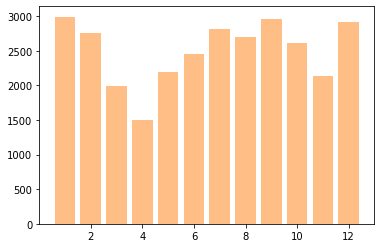

In [115]:
R = 1000
N= []
# for i,d in enumerate(data):
N.append(len(d))

sim = model_ppc.sample(
    data=data_sim,
    iter_sampling=R,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=42,
    refresh=R
)

accidents_pred_prior = sim.stan_variable("accidents_pred")
accidents_pred_prior_means = np.mean(accidents_pred_prior, axis=0)

plt.bar(list(d["month"]), accidents_pred_prior_means, alpha=0.5)
plt.bar(list(d["month"]), list(d["crashes"]), alpha=0.5)
# plt.legend([f"prior predictions", f"{data_labels[i]}"], loc='lower left')
# plt.xlabel('year')
# plt.ylabel('Yields [dt/ha]') 
# plt.title(f'Comparison of {data_labels[i]} and prior predictions') 
plt.show()

In [7]:
R = 1000
sim = model_ppc.sample(data=data_sim, 
                       output_dir='samples', 
                       iter_sampling=R, 
                       iter_warmup=None, 
                       chains=1, 
                       refresh=R,
                       fixed_param=True,
                       seed=29042020)

a_sim = sim.stan_variable('a')
b_sim = sim.stan_variable('b')
c_sim = sim.stan_variable('c')

INFO:cmdstanpy:created output directory: /home/Data_Analytics/crashes/model/samples
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [8]:
# helper functions to plot histograms
def plothist(data: np.ndarray, 
             bins: int = 25, 
             density: bool = True,
             x_label: str = '', 
             y_label: str = '', 
             title: str = '') -> None:
    plt.hist(data, bins=bins, density=density, alpha=0.8, edgecolor='black')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'Histogram of {title}')
    plt.show()

def plotcomparehist(data1: np.ndarray,
                    data2: np.ndarray, 
                    bins1: int = 25,
                    bins2: int = 25, 
                    density1: bool = True,
                    density2: bool = True,
                    x_label1: str = '',
                    x_label2: str = '', 
                    y_label1: str = '',
                    y_label2: str = '', 
                    title: str = '') -> None:
    
    _, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].hist(data1, bins=bins1, density=density1, alpha=0.8, edgecolor='black')
    ax[0].set_xlabel(x_label1)
    ax[0].set_ylabel(y_label1)
    ax[0].set_title(f'Actual data of {title}')
    
    ax[1].hist(data2, bins=bins2, density=density2, alpha=0.8, edgecolor='black')
    ax[1].hist(data1, bins=bins1, density=density1, histtype='step', color='C1')
    ax[1].set_xlabel(x_label2)
    ax[1].set_ylabel(y_label2)
    ax[1].set_title(f'Predicted data of {title}')

    plt.show()

In [10]:
a_sim.shape

(1000,)

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(list(d['month']), d['crashes'].values, alpha=0.5)
ax1.bar(list(d['month']), np.mean(a_fit, axis=0), alpha=0.5)
plt.show()

In [131]:
with open(f'{STAN_PATH}/prior2.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    // array[N] real avg_temp;
    // array[N] real<lower=0> rainfall;
    array[N] real<lower=0, upper=100> humidity;
}

generated quantities {
    real a = abs(normal_rng(0, 90));
    // real b = normal_rng(0, 10);
    // real c = normal_rng(10, 10);

    // real<lower=0> sigma = exponential_rng(0.5);

    array[N] int<lower=0> accidents_pred;
    for (i in 1:N) {
        accidents_pred[i] = poisson_rng(a*humidity[i]);
    }
}




In [158]:
model_ppc = CmdStanModel(stan_file=f'{STAN_PATH}/prior2.stan')

INFO:cmdstanpy:compiling stan file /home/Data_Analytics/crashes/model/stan/prior2.stan to exe file /home/Data_Analytics/crashes/model/stan/prior2


INFO:cmdstanpy:compiled model executable: /home/Data_Analytics/crashes/model/stan/prior2


In [159]:
data_sim = {
    'N': len(d), 
    'avg_temp': d['avg_temp'],
    'rainfall': d['rainfall'],
    'humidity': d['humidity']}

In [160]:
R = 1000
N= []
# for i,d in enumerate(data):
N.append(len(d))

sim = model_ppc.sample(
    data=data_sim,
    iter_sampling=R,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=42,
    refresh=R
)

accidents_pred_prior = sim.stan_variable("accidents_pred")
accidents_pred_prior_means = np.mean(accidents_pred_prior, axis=0)

plt.bar(list(d["month"]), accidents_pred_prior_means, alpha=0.5)
plt.bar(list(d["month"]), list(d["crashes"]), alpha=0.5)
# plt.legend([f"prior predictions", f"{data_labels[i]}"], loc='lower left')
# plt.xlabel('year')
# plt.ylabel('Yields [dt/ha]') 
# plt.title(f'Comparison of {data_labels[i]} and prior predictions') 
plt.show()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


## Task 2. Model fit and evaluation

In [12]:
with open(f'{STAN_PATH}/fit1.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    array[N] real avg_temp;
    array[N] real<lower=0> rainfall;
    array[N] real<lower=0, upper=100> humidity;
    array[N] real<lower=0> accidents;
}

parameters {
    real a;
    real b;
    real c;
    real<lower=0> sigma;
}

model {
    a ~ normal_rng(0, 10);
    b ~ normal_rng(0, 10);
    c ~ normal_rng(0, 10);
    sigma ~ exponential_rng(0.5);

    for (i in 1:N) {
        accidents ~ normal_rng(a*avg_temp[i] + b*rainfall[i] + c*humidity[i], sigma);
    }
}

generated quantities {
    array[N] real accidents_pred;
    for (i in 1:N) {
        accidents_pred[i] = normal_rng(a*avg_temp[i] + b*rainfall[i] + c*humidity[i], sigma);
    }
}



In [42]:
model_1_fit = CmdStanModel(stan_file=f'{STAN_PATH}/fit1.stan')

INFO:cmdstanpy:compiling stan file /home/Data_Analytics/crashes/model/stan/fit1.stan to exe file /home/Data_Analytics/crashes/model/stan/fit1


INFO:cmdstanpy:compiled model executable: /home/Data_Analytics/crashes/model/stan/fit1


In [43]:
data_sim = {
    'N': len(d), 
    # 'avg_temp': d['avg_temp'],
    # 'rainfall': d['rainfall'],
    'humidity': d['humidity'],
    'accidents': d['crashes']}

In [44]:
fit = model_1_fit.sample(data=data_sim,
                         output_dir='samples', 
                         seed=28052020)

a_fit = fit.stan_variable('a')
# b_fit = fit.stan_variable('b')
c_fit = fit.stan_variable('c')
accidents_pred = fit.stan_variable('accidents_pred')

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status

chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


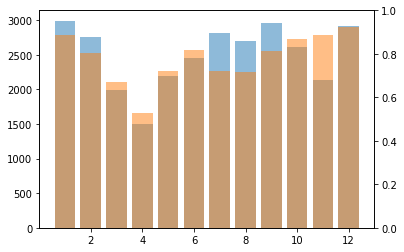

In [130]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(list(d['month']), d['crashes'].values, alpha=0.5)
ax1.bar(list(d['month']), np.mean(accidents_pred, axis=0), alpha=0.5)
# ax2.invert_yaxis()
# ax2.set_yticks(np.arange(1, 21))
# ax2.set_yticklabels([i+1 for i in range(20)])
# ax2.scatter(list(d_new['driver_name']), d_new.race_position, color='r')
plt.show()

poisson

In [ ]:
with open(f'{STAN_PATH}/fit2.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    array[N] real avg_temp;
    array[N] real<lower=0> rainfall;
    array[N] real<lower=0, upper=100> humidity;
    array[N] real<lower=0> accidents;
}

parameters {
    real a;
    real b;
    real c;
    real<lower=0> sigma;
}

model {
    a ~ normal_rng(0, 10);
    b ~ normal_rng(0, 10);
    c ~ normal_rng(0, 10);
    sigma ~ exponential_rng(0.5);

    for (i in 1:N) {
        accidents ~ normal_rng(a*avg_temp[i] + b*rainfall[i] + c*humidity[i], sigma);
    }
}

generated quantities {
    array[N] real accidents_pred;
    for (i in 1:N) {
        accidents_pred[i] = normal_rng(a*avg_temp[i] + b*rainfall[i] + c*humidity[i], sigma);
    }
}



In [ ]:
model_1_fit = CmdStanModel(stan_file=f'{STAN_PATH}/fit1.stan')

INFO:cmdstanpy:compiling stan file /home/Data_Analytics/crashes/model/stan/fit1.stan to exe file /home/Data_Analytics/crashes/model/stan/fit1


INFO:cmdstanpy:compiled model executable: /home/Data_Analytics/crashes/model/stan/fit1


In [ ]:
data_sim = {
    'N': len(d), 
    # 'avg_temp': d['avg_temp'],
    # 'rainfall': d['rainfall'],
    'humidity': d['humidity'],
    'accidents': d['crashes']}

In [ ]:
fit = model_1_fit.sample(data=data_sim,
                         output_dir='samples', 
                         seed=28052020)

a_fit = fit.stan_variable('a')
# b_fit = fit.stan_variable('b')
c_fit = fit.stan_variable('c')
accidents_pred = fit.stan_variable('accidents_pred')

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status

chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


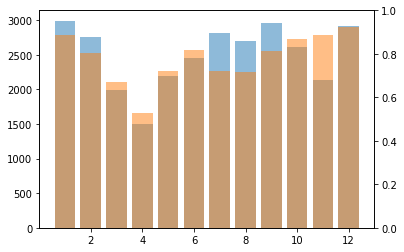

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(list(d['month']), d['crashes'].values, alpha=0.5)
ax1.bar(list(d['month']), np.mean(accidents_pred, axis=0), alpha=0.5)
# ax2.invert_yaxis()
# ax2.set_yticks(np.arange(1, 21))
# ax2.set_yticklabels([i+1 for i in range(20)])
# ax2.scatter(list(d_new['driver_name']), d_new.race_position, color='r')
plt.show()

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [ ]:
# create column 'c_weight'
d['c_weight'] = d.weight - d.weight.mean()

In [ ]:
data_sim = {
    'N': 50, 
    'weight': np.linspace(d.c_weight.min(), d.c_weight.max())
}

## Task 4. Prior predictive checks
 

In [ ]:
with open('height_2a_ppc.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    array[N] real weight;
}

generated quantities {
    real alpha = normal_rng(175, 20);
    real beta = normal_rng(0, 10);
    real sigma = exponential_rng(0.067);
    array[N] real height;
    for (i in 1:N) {
        height[i] = normal_rng(alpha + beta * weight[i], sigma);
    }
}



In [ ]:
model_ppc = CmdStanModel(stan_file='height_2a_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [ ]:
R = 1000
sim = model_ppc.sample(data=data_sim, 
                       output_dir='samples', 
                       iter_sampling=R, 
                       iter_warmup=None, 
                       chains=1, 
                       refresh=R,
                       fixed_param=True,
                       seed=29042020)

alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

In [ ]:
# plot lines for each sampled slope 'beta' and intercept 'alpha'
for i in range(alpha_sim.shape[0]):
    plt.plot(d.weight, alpha_sim[i] + beta_sim[i] * d.c_weight, 'C0', linewidth=0.1)

# plot range of real peoples height
plt.hlines([0, 272], xmin=d.weight.min(), xmax=d.weight.max(), linestyles='--', color='black')
plt.xlabel('weight [kg]')
plt.ylabel('height [cm]')
plt.title(fr'Lines for each $\alpha$ and $\beta$')
plt.show()

#### **Conclusion**
Possible predicted heights are not at all consistent with rational values of peoples height.Tallest person in history was 272 cm. 

$\beta$ parameter responsible for the slope of the plotted lines has some serious flaws.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [ ]:
with open('height_2b_ppc.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    array[N] real weight;
}

generated quantities {
    real alpha = normal_rng(175, 20);
    real beta = lognormal_rng(0, 1);
    real sigma = exponential_rng(0.067);
    array[N] real height;
    for (i in 1:N) {
        height[i] = normal_rng(alpha + beta * weight[i], sigma);
    }
}



In [ ]:
model_ppc = CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [ ]:
sim = model_ppc.sample(data=data_sim, 
                       output_dir='samples', 
                       iter_sampling=R, 
                       iter_warmup=None, 
                       chains=1, 
                       refresh=R,
                       fixed_param=True,
                       seed=29042020)

alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')
height_sim = sim.stan_variable('height')

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

In [ ]:
d.weight.shape

(352,)

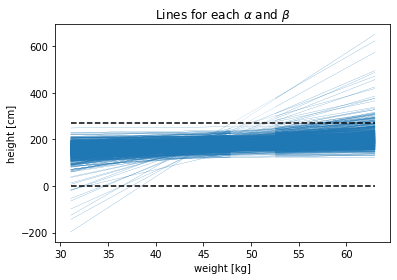

In [ ]:
###  1.

# plot lines for each sampled slope 'beta' and intercept 'alpha'
for i in range(alpha_sim.shape[0]):
    plt.plot(d.weight, alpha_sim[i] + beta_sim[i] * d.c_weight, 'C0', linewidth=0.1)

# plot range of real peoples height
plt.hlines([0, 272], xmin=d.weight.min(), xmax=d.weight.max(), linestyles='--', color='black')
plt.xlabel('weight [kg]')
plt.ylabel('height [cm]')  
plt.title(fr'Lines for each $\alpha$ and $\beta$')
plt.show()

In [ ]:
# ribbot plot with quantiles marked
def ribbon_plot(x: np.ndarray, 
                data: np.ndarray, 
                observed_data_x: Optional[np.ndarray] = None,
                observed_data_y: Optional[np.ndarray] = None,
                quantiles: list[int | float] = [5, 25, 50], 
                xlabel: str = '',
                ylabel: str = '',
                title: str = '',
                data_axis: int = 1,
                errorbar: bool = False,
                errorbar_factor: float = 1) -> None:
    # prepare quantiles
    for idx, quantile in enumerate(quantiles):
        if quantile < 0 or quantile > 100:
            raise ValueError
        if quantile > 50:
            quantiles[idx] = 100 - quantile
    quantiles = sorted(set(quantiles))

    # prepare stats data
    dmean = data.mean(axis=data_axis)
    dstd = data.std(axis=data_axis)
    dmin = data.min(axis=data_axis)
    dmax = data.max(axis=data_axis)

    # sort data to plotting
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    dmean = dmean[sorted_indices]
    dstd = dstd[sorted_indices]
    dmin = dmin[sorted_indices]
    dmax = dmax[sorted_indices]    

    # plot ribbons
    for idx, quantile in enumerate(quantiles):
        if quantile == 0:
            plt.plot(x, dmin, c='C0')
            plt.plot(x, dmax, c='C0')
            plt.fill_between(x, dmin, dmax, color='Blue', alpha=(idx+1)/len(quantiles)*0.5)
            continue

        z_score = stats.norm.ppf(quantile / 100)
        min_val = dmean - dstd * z_score
        max_val = dmean + dstd * z_score

        plt.plot(x, min_val, c='C0')
        plt.plot(x, max_val, c='C0')
        plt.fill_between(x, min_val, max_val, color='Blue', alpha=(idx+1)/len(quantiles)*0.5)
        # plot errorbar of errorbar_factor * std
        if errorbar:
            plt.errorbar(x=x, y=min_val, yerr=errorbar_factor*dstd, ecolor='gray', elinewidth=1, alpha=0.7)
    
    # plot observed data
    if observed_data_x is not None and observed_data_y is not None:
        plt.scatter(observed_data_x, observed_data_y, color='k', s=10)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()

In [ ]:
###  2.

# ribbon plot with min and max values 
ribbon_plot(data_sim['weight']+d.weight.mean(),
            height_sim, 
            observed_data_x=d.weight.values, 
            observed_data_y=d.height.values, 
            quantiles=[0, 5, 25, 50, 75, 95, 100], 
            data_axis=0, 
            xlabel='weight [kg]', 
            ylabel='height [cm]', 
            title='Simulated height')

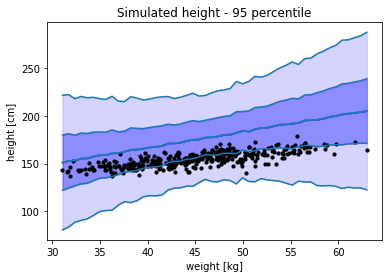

In [ ]:
# ribbon plot without min and max values 
ribbon_plot(data_sim['weight']+d.weight.mean(), 
            height_sim, 
            observed_data_x=d.weight.values, 
            observed_data_y=d.height.values, 
            quantiles=[5, 25, 50, 75, 95], 
            data_axis=0, 
            xlabel='weight [kg]', 
            ylabel='height [cm]', 
            title='Simulated height - 95 percentile')

#### **Conclusion**
Predicted heights are now mostly consistent with heights observed in nature (between horizontal black lines). However for bigger values of weight height still is above expected avarage. 



## Task 6. Fitting and evaluating model


In [ ]:
with open('height_2_fit.stan', 'r') as file:
    print(file.read())

data {
    int N;
    array[N] real weight;
    array[N] real heights;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

transformed parameters {
    array[N] real mu;
    for (i in 1:N) {
        mu[i] = alpha + beta * weight[i];
    }
}

model {
    alpha ~ normal(175, 20);
    beta ~ lognormal(0, 1);
    sigma ~ exponential(0.067);
    for (i in 1:N) {
        heights[i] ~ normal(mu[i], sigma);
    }
}

generated quantities {
    array[N] real height;
    for (i in 1:N) {
        height[i] = normal_rng(mu[i], sigma);
    }
}



In [ ]:
model_2_fit = CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [ ]:
###  1.

N = 150
d_head = d.head(N)
data_fit = {
    'N'       : len(d_head), 
    'weight'  : d_head.c_weight.values,
    'heights' : d_head.height.values
}

In [ ]:
fit = model_2_fit.sample(data=data_fit, 
                         output_dir='samples', 
                         seed=28052020,
                         show_progress=False)
alpha_fit = fit.stan_variable('alpha')
beta_fit = fit.stan_variable('beta')
mu_fit = fit.stan_variable('mu')
height_pred = fit.stan_variable('height')

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


In [ ]:
az.summary(fit, var_names=['alpha', 'beta', 'sigma'], kind='stats')

mean     sd   hdi_3%  hdi_97%
alpha  153.840  0.452  152.984  154.705
beta     0.898  0.065    0.770    1.015
sigma    5.506  0.321    4.928    6.117

In [ ]:
###  2.

# plot lines for each sampled slope 'beta' and intercept 'alpha'
for i in range(1000):   # alpha_fit.shape[0]
    plt.plot(d_head.weight, alpha_fit[i] + beta_fit[i] * d_head.c_weight, color='C0', linewidth=0.1, alpha=0.4)

plt.scatter(d_head.weight.values, d_head.height.values, color='k', s=10)
# plot range of real peoples height
plt.xlabel('weight [kg]')
plt.ylabel('height [cm]')
plt.title(fr'Lines for each $\alpha$ and $\beta$')
plt.show()

In [ ]:
###  veryfication of uncertainity based on number of samples 'N'

def sample_fit(N: int, 
               data,
               quantiles = [0, 5, 15, 25, 35, 45, 50],
               observed_data = True,
               errorbar = False):
    d_head = data.head(N)
    data_fit = {
        'N'       : N, 
        'weight'  : d_head.c_weight.values,
        'heights' : d_head.height.values
    }
    fit = model_2_fit.sample(data=data_fit, 
                             output_dir='samples', 
                             seed=28052020,
                             show_progress=False)
    mu_fit = fit.stan_variable('mu')
    height_pred = fit.stan_variable('height')

    observed_data_x = None
    observed_data_y = None
    if observed_data:
        observed_data_x=d_head.weight.values 
        observed_data_y=d_head.height.values

    ribbon_plot(x=d_head.weight.values,
                data=height_pred,  # mu_fit, 
                observed_data_x=observed_data_x, 
                observed_data_y=observed_data_y, 
                quantiles=quantiles, 
                data_axis=0, 
                errorbar=errorbar,
                xlabel='weight [kg]', 
                ylabel='height [cm]', 
                title=f'Simulated height - {N} samples; 95th percentile')

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing


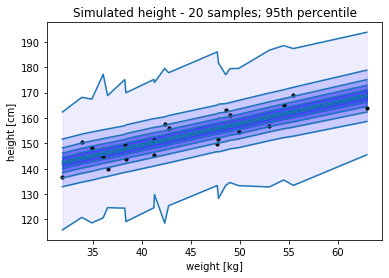

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing


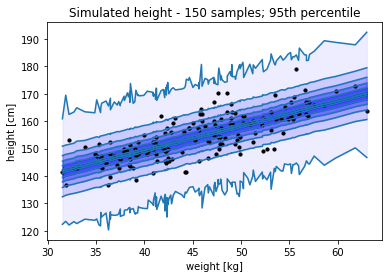

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


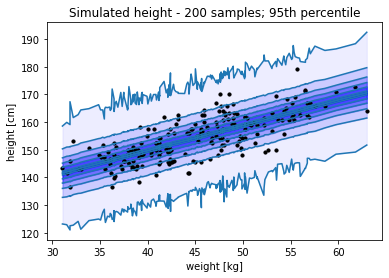

In [ ]:
# plot ribbon plots for differen number of fitted samples
for n in [10, 20, 50, 100, 150, 200]:
    sample_fit(N=n, data=d)

### **Conclusion**
Most of the points are in the 95th percentile, which means that this model is performing well.

Based on the plots above number of samples `N` have almost no effect on fitting.

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing


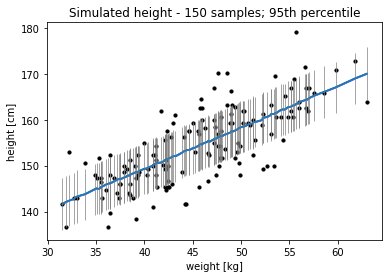

In [ ]:
###  3.

sample_fit(N=150, data=d, quantiles=[50], errorbar=True)

#### **Conclusion**
The same conclusion as above. `plt.errorbar` draws exactly the same boudaries as 16th percentile

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

In [ ]:
###  1.

# ALREADY DONE

#### **Conclusion**
The weight data was centered in **Task 3**.

Updated model:

$$ y \sim \mathrm{Normal}(\alpha+X\beta+X^2\gamma,\sigma) $$

In [ ]:
###  2.

with open('height_3_ppc.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    array[N] real weight;
}

generated quantities {
    real alpha = normal_rng(175, 20);
    real beta = lognormal_rng(0, 1);
    real gamma = normal_rng(0, 10);
    real sigma = exponential_rng(0.067);
    array[N] real height;

    for (i in 1:N) {
        height[i] = normal_rng(alpha + beta * weight[i] + gamma * weight[i]^2, sigma);
    }
}



In [ ]:
model_ppc = CmdStanModel(stan_file='height_3_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/Data_Analytics/Lab4_modified/height_3_ppc.stan to exe file /home/Data_Analytics/Lab4_modified/height_3_ppc
INFO:cmdstanpy:compiled model executable: /home/Data_Analytics/Lab4_modified/height_3_ppc


In [ ]:
sim = model_ppc.sample(data=data_sim, 
                       output_dir='samples', 
                       iter_sampling=R, 
                       iter_warmup=None, 
                       chains=1, 
                       refresh=R,
                       fixed_param=True,
                       seed=29042020)

alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')
gamma_sim = sim.stan_variable('gamma')
height_sim = sim.stan_variable('height')

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


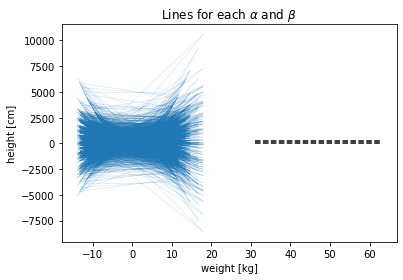

In [ ]:
###  1.

# plot lines for each sampled slope 'beta' and intercept 'alpha'
for i in range(100):   # alpha_sim.shape[0]
    plt.plot(d.c_weight, alpha_sim[i] + beta_sim[i] * d.c_weight + gamma_sim[i] * d.c_weight**2, 'C0', linewidth=0.1)

# plot range of real peoples height
plt.hlines([0, 272], xmin=d.weight.min(), xmax=d.weight.max(), linestyles='--', color='black')
plt.xlabel('weight [kg]')
plt.ylabel('height [cm]')
plt.title(fr'Lines for each $\alpha$ and $\beta$')
plt.show()

In [ ]:
# ribbot plot with quantiles marked
def ribbon_plot(x: np.ndarray, 
                data: np.ndarray, 
                observed_data_x: Optional[np.ndarray] = None,
                observed_data_y: Optional[np.ndarray] = None,
                quantiles: list[int | float] = [5, 25, 50], 
                xlabel: str = '',
                ylabel: str = '',
                title: str = '',
                data_axis: int = 1,
                errorbar: bool = False,
                errorbar_factor: float = 1) -> None:
    # prepare quantiles
    for idx, quantile in enumerate(quantiles):
        if quantile < 0 or quantile > 100:
            raise ValueError
        if quantile > 50:
            quantiles[idx] = 100 - quantile
    quantiles = sorted(set(quantiles))

    # prepare stats data
    dmean = data.mean(axis=data_axis)
    dstd = data.std(axis=data_axis)
    dmin = data.min(axis=data_axis)
    dmax = data.max(axis=data_axis)

    # sort data to plotting
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    dmean = dmean[sorted_indices]
    dstd = dstd[sorted_indices]
    dmin = dmin[sorted_indices]
    dmax = dmax[sorted_indices]    

    # plot ribbons
    for idx, quantile in enumerate(quantiles):
        if quantile == 0:
            plt.plot(x, dmin, c='C0')
            plt.plot(x, dmax, c='C0')
            plt.fill_between(x, dmin, dmax, color='Blue', alpha=(idx+1)/len(quantiles)*0.5)
            continue

        z_score = stats.norm.ppf(quantile / 100)
        min_val = dmean - dstd * z_score
        max_val = dmean + dstd * z_score

        plt.plot(x, min_val, c='C0')
        plt.plot(x, max_val, c='C0')
        plt.fill_between(x, min_val, max_val, color='Blue', alpha=(idx+1)/len(quantiles)*0.5)
        # plot errorbar of errorbar_factor * std
        if errorbar:
            plt.errorbar(x=x, y=min_val, yerr=errorbar_factor*dstd, ecolor='gray', elinewidth=1, alpha=0.7)
    
    # plot observed data
    if observed_data_x is not None and observed_data_y is not None:
        plt.scatter(observed_data_x, observed_data_y, color='k', s=10)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()

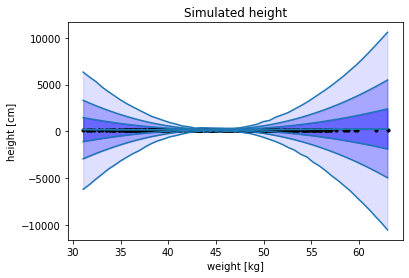

In [ ]:
###  2.

# ribbon plot with min and max values 
ribbon_plot(data_sim['weight']+d.weight.mean(),
            height_sim, 
            observed_data_x=d.weight.values, 
            observed_data_y=d.height.values, 
            quantiles=[0, 5, 25, 50, 75, 95, 100], 
            data_axis=0, 
            xlabel='weight [kg]', 
            ylabel='height [cm]', 
            title='Simulated height')

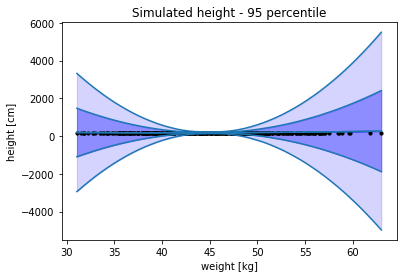

In [ ]:
# ribbon plot without min and max values 
ribbon_plot(data_sim['weight']+d.weight.mean(), 
            height_sim, 
            observed_data_x=d.weight.values, 
            observed_data_y=d.height.values, 
            quantiles=[5, 25, 50, 75, 95], 
            data_axis=0, 
            xlabel='weight [kg]', 
            ylabel='height [cm]', 
            title='Simulated height - 95 percentile')

In [ ]:
###  3.

with open('height_2_fit_vec.stan', 'r') as file:
    print(file.read())

data {
    int N;
    vector[N] weight;
    array[N] real heights;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

transformed parameters {
    vector[N] mu = alpha + beta * weight;
}

model {
    alpha ~ normal(175, 20);
    beta ~ lognormal(0, 1);
    sigma ~ exponential(0.067);
    heights ~ normal(mu, sigma);
}

generated quantities {
    array[N] real height;
    for (i in 1:N) {
        height[i] = normal_rng(mu[i], sigma);
    }
}



In [ ]:
###  2.

model_2_fit_vec = CmdStanModel(stan_file='height_2_fit_vec.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [ ]:
N = 150
d_head = d.head(N)
data_fit = {
    'N'       : len(d_head), 
    'weight'  : d_head.c_weight.values,
    'heights' : d_head.height.values
}

In [ ]:
fit = model_2_fit_vec.sample(data=data_fit, 
                         output_dir='samples', 
                         seed=28052020,
                         show_progress=False)
alpha_fit = fit.stan_variable('alpha')
beta_fit = fit.stan_variable('beta')
mu_fit = fit.stan_variable('mu')
height_pred = fit.stan_variable('height')

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
